# Twitter Language Data EDA

```




```
- tokenise the data using unigram and bigram methods
- show the unique number of words, tweets, and handles for the overall data set and each handle in turn
- show a stacked barplot coloured by each handle over time showing the number of tweets

**Word Clouds**
- build a word cloud for all the data
- build individual work clouds for each of the handles
- add sentiment to the word clouds. If you have a sentiment dictionary then you can apply that to the uni and bigrams. Then you can colour positive words green, negative words red and neutral words grey. If your hackathon three model has worked then you can use this model instead to estimate the sentiment of the words in the clouds.

**Topic Analysis**
- apply a topic modelling approach to extract around 10 of the major topics being discussed in the full dataset
- build a directed graph based on replies and retweets where each node is a tweet and the edges are generated on the basis of reply or retweet of that tweet. In this way you can show the most dominant tweets, based on most retweets and replies. Also you can apply graph clustering methods to cluster the tweets themselves into different groups. This is essentially another form of topic analysis.

**Community detection**
- you can build yet another graph but this time based on users. Each user is a node and they are connected if they have tweeted at each other either by reply or retweet. A reply creates an edge in the direction of the person being replied to. A retweet creates an edge in the direction of the person retweeting. With this graph you can now determine which twitter users are the most influential based on their degree (number of nodes entering or leaving). Finally you can cluster this graph to reveal different groups of twitter users.

```




```
### Content
```




```
- [Read data](#Read-data)
- [Distributions](#Distributions)
    - [Tweets over time](#Tweets-over-time)
    - [Language and location heatmaps](#Language-and-location-heatmaps)
- [Word clouds](#Word-clouds)
    - [Overall wordclouds](#Overall-wordclouds)
    - [Query language wordclouds](#Query-language-wordclouds)
    - [Predicted language wordclouds](#Predicted-language-wordclouds)
- [Topic Analysis](#Topic-analysis)
- [Test on unseen data](#Test-on-unseen-data)
- [Final notes](#Final-notes)

In [1]:
import os
import sys
import json
import pickle

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
# import config

%matplotlib inline

from sklearn.model_selection import train_test_split

In [2]:
MODULES_PATH = '../modules'
MODELS_PATH = '../models'
DATA_PATH = '../data'

sys.path.append(MODULES_PATH)
from data import flatten_data, prepare_training_data, prepare_test_data
from models import simple_ffn

Using TensorFlow backend.


## Read data

In [3]:
tweets = pd.read_json(os.path.join(DATA_PATH,'tweets_predicted.json'))

In [382]:
tweets.shape

(572414, 42)

```




```
## Distributions

- [back to content](#Content)

**content**
- [Tweets over time](#Tweets-over-time)
- [Language and location heatmaps](#Language-and-location-heatmaps)

### Twitter language distribution

In [23]:
top_twitter_lang_name = tweets['twitter_lang_name'].value_counts().reset_index()[0:9]

top_twitter_lang_name = top_twitter_lang_name.append({'index':'other',
                               'twitter_lang_name':tweets['twitter_lang_name'].value_counts()[9::].sum()
                              }, ignore_index=True)

# top_twitter_lang_name

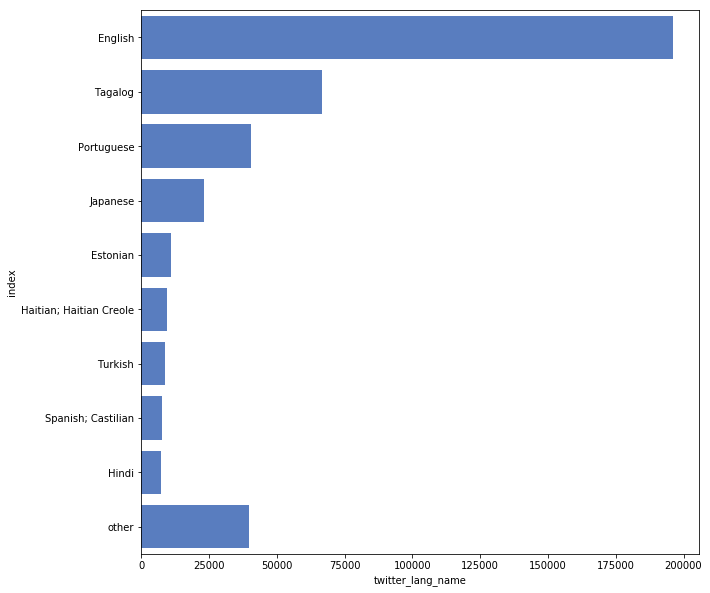

In [24]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.set_color_codes("muted")
sns.barplot(x="twitter_lang_name", y="index", data=top_twitter_lang_name,
            label="Total", color="b", ax=ax)

### Search query distribution

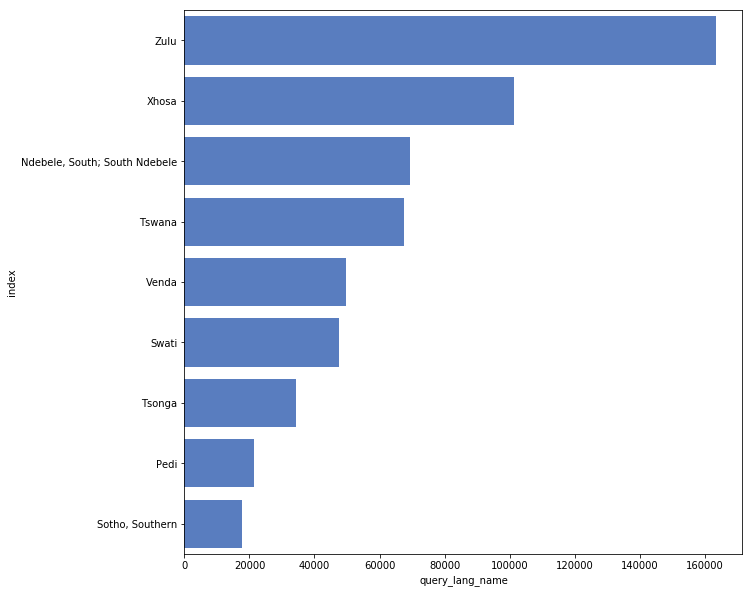

In [25]:
# from matplotlib import cm
# tweets['our_lang'].value_counts().plot.bar(figsize=(15,5), cmap=cm.get_cmap('Spectral'))

fig, ax = plt.subplots(figsize=(10, 10))

sns.set_color_codes("muted")
sns.barplot(x="query_lang_name", y="index", data=tweets['query_lang_name'].value_counts().reset_index(),
            label="Total", color="b", ax=ax)

## Tweets over time

- [back to content](#Content)
- [back to section](#Distributions)

In [64]:
tweets.columns

Index(['created_at', 'id_str', 'lang', 'max_prob', 'nr', 'nso', 'our_lang',
       'pred_lang', 'pred_lang_name', 'query_lang_name',
       'quoted_status.created_at', 'quoted_status.id_str',
       'quoted_status.text', 'quoted_status.user.screen_name',
       'retweeted_status.created_at', 'retweeted_status.id_str',
       'retweeted_status.text', 'retweeted_status.user.screen_name', 'ss',
       'st', 'text', 'tn', 'ts', 'twitter_lang_name', 'user.description',
       'user.favourites_count', 'user.followers_count', 'user.friends_count',
       'user.id_str', 'user.lang', 'user.listed_count', 'user.location',
       'user.name', 'user.screen_name', 'user.statuses_count',
       'user.time_zone', 'user.utc_offset', 've', 'xh', 'zu'],
      dtype='object')

In [78]:
tweets['date'] = tweets['created_at'].dt.strftime(date_format='%d/%m/%Y')

In [121]:
tweets['date_m'] = tweets['created_at'].dt.strftime(date_format='%m/%d/%Y')

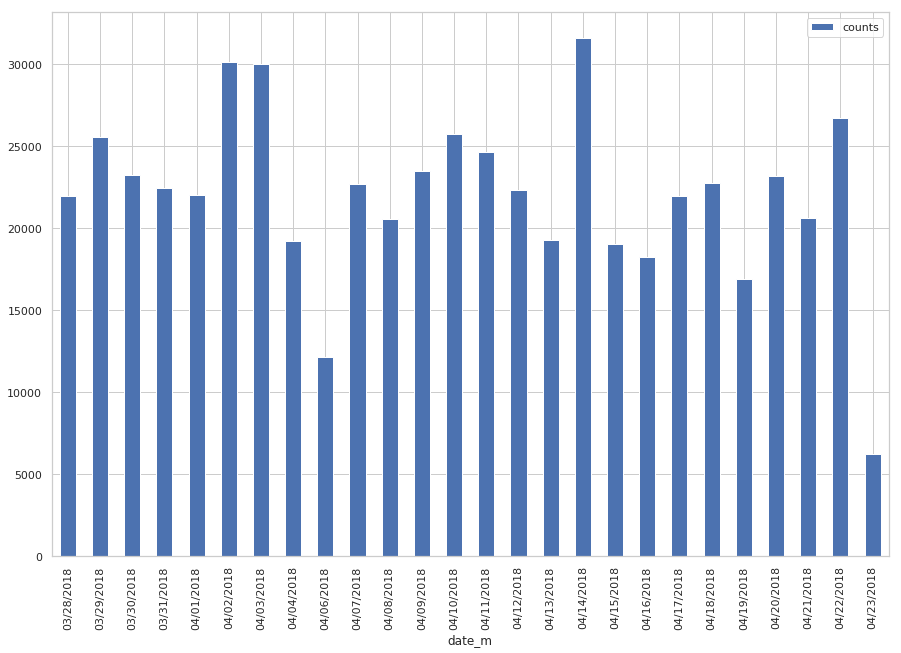

In [126]:
tweet_dates = tweets['date_m'].value_counts().reset_index().sort_values('index')
tweet_dates.columns = ['date_m','counts']

tweet_dates.index = tweet_dates['date_m']

tweet_dates.plot.bar(figsize=(15,10))

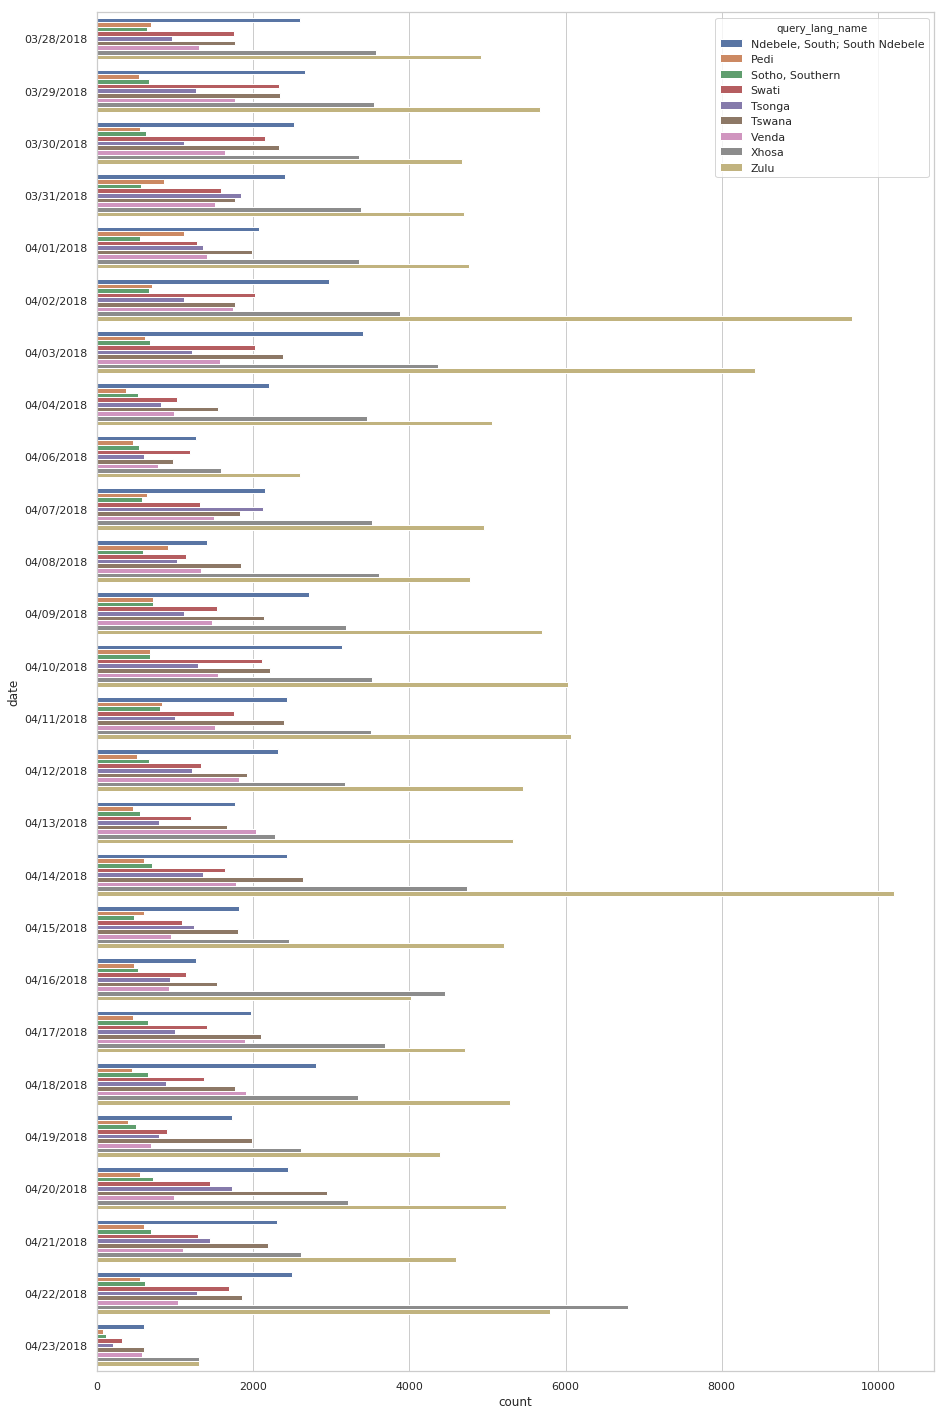

In [125]:
df_pivot = pd.pivot_table(tweets[['date_m','query_lang_name','user.location']], 
               index='date_m', 
               columns='query_lang_name', 
               aggfunc='count')
df_pivot.columns


df_pivot = df_pivot['user.location'].unstack().reset_index()
df_pivot.columns = ['query_lang_name','date','count']

fig, ax = plt.subplots(figsize=(15, 25))
sns.set(style="whitegrid")
sns.barplot(x="count", y="date", hue="query_lang_name", data=df_pivot, ax=ax)

## Language and location heatmaps

### Language code - query comparison


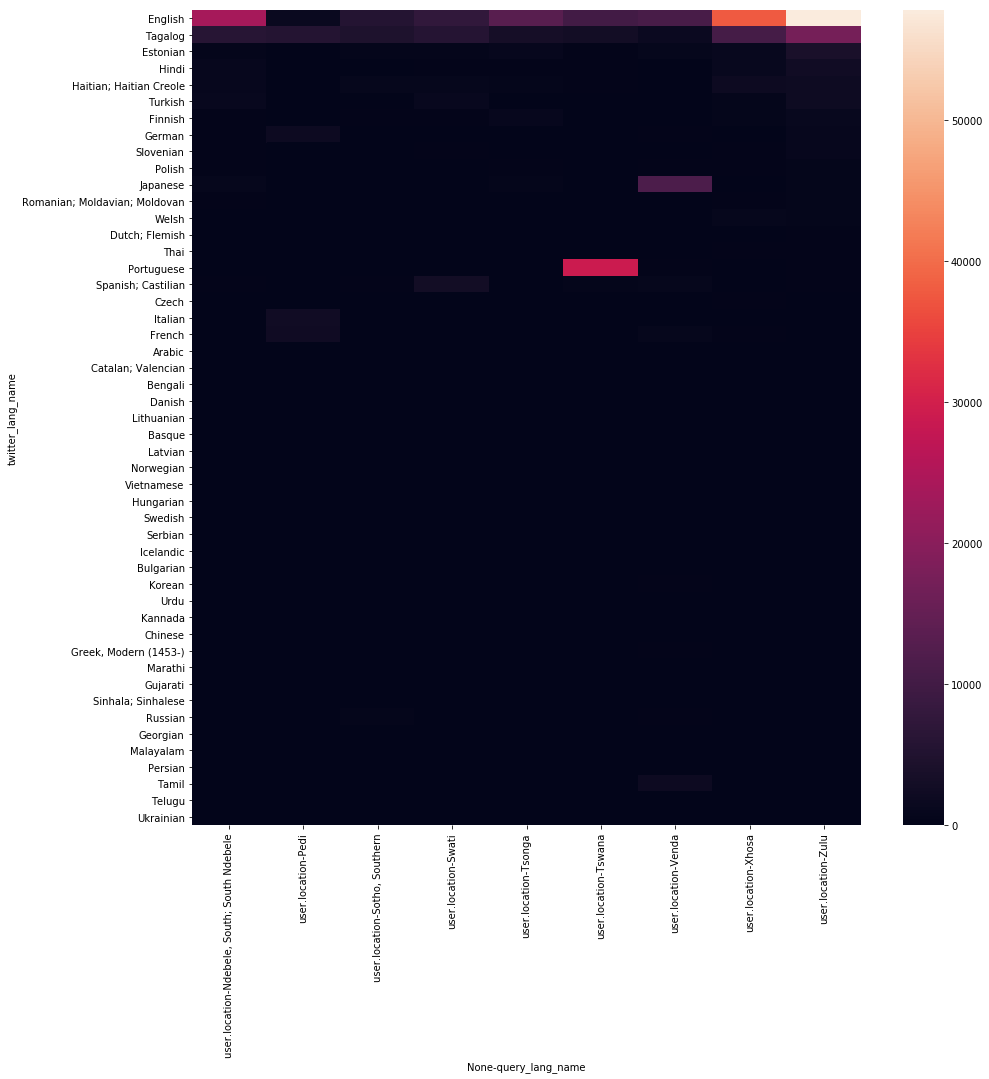

In [29]:
df_pivot = pd.pivot_table(tweets[['twitter_lang_name','query_lang_name','user.location']], 
               index='twitter_lang_name', 
               columns='query_lang_name', 
               aggfunc='count')

idx = df_pivot[('user.location', 'Zulu')].reset_index().sort_values(('user.location', 'Zulu'),ascending=False).index

fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_pivot.fillna(0).iloc[idx.tolist()], ax=ax)

# somewhat expected distributions over en, in, tl and und with zu, xh and nr at the top
#  there is an unexpected spike at pl - ve and pt - tn

### Location - twitter language comparison

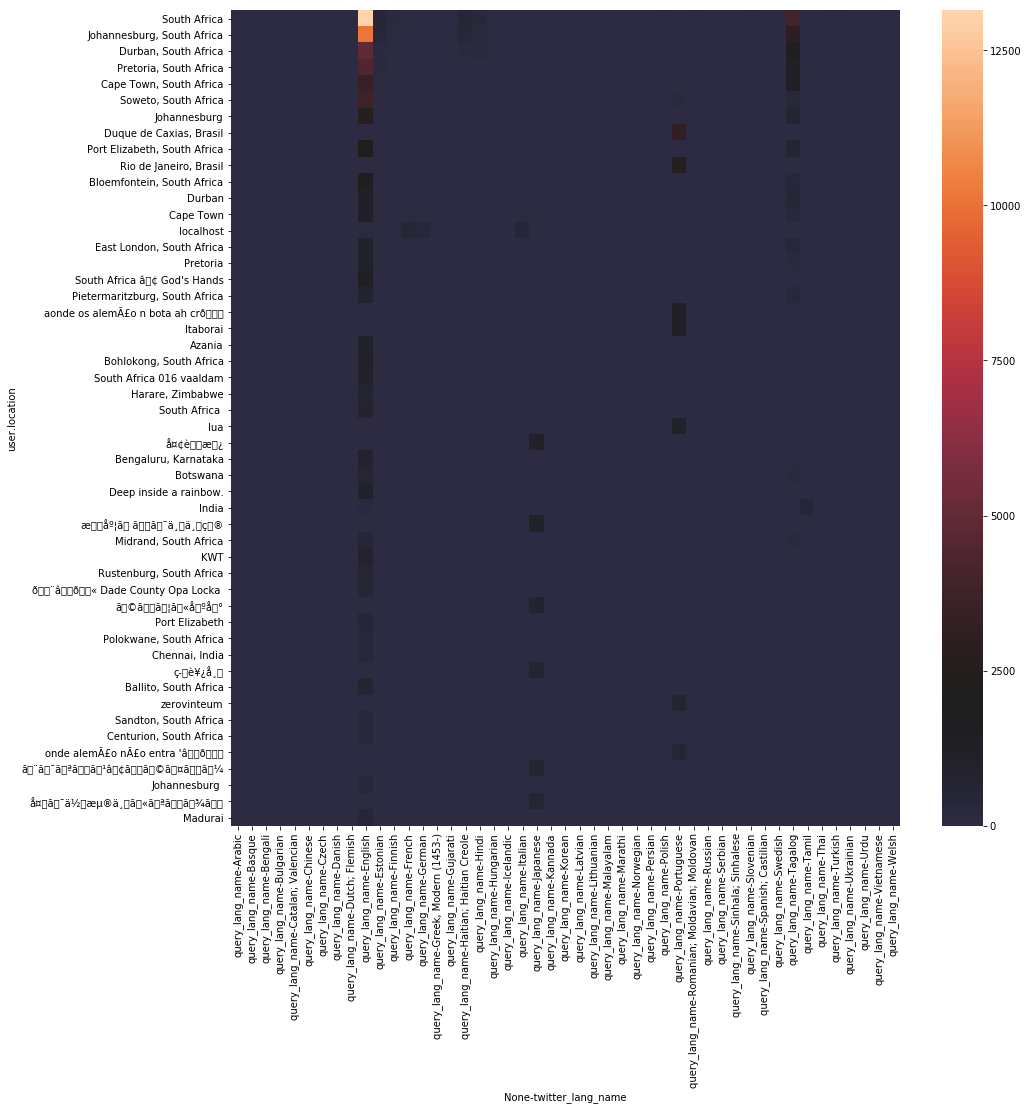

In [57]:
df_pivot = pd.pivot_table(tweets[['twitter_lang_name','query_lang_name','user.location']], 
               index='user.location', 
               columns='twitter_lang_name', 
               aggfunc='count')

df_summed = df_pivot.fillna(0).sum(axis=1).reset_index()

df_summed.columns = ['user.location', 'count']
idx = df_summed.sort_values(by='count',ascending=False).index

fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_pivot.fillna(0).iloc[idx.tolist()].iloc[0:50], center=2000, ax=ax)

### Location - query comparison

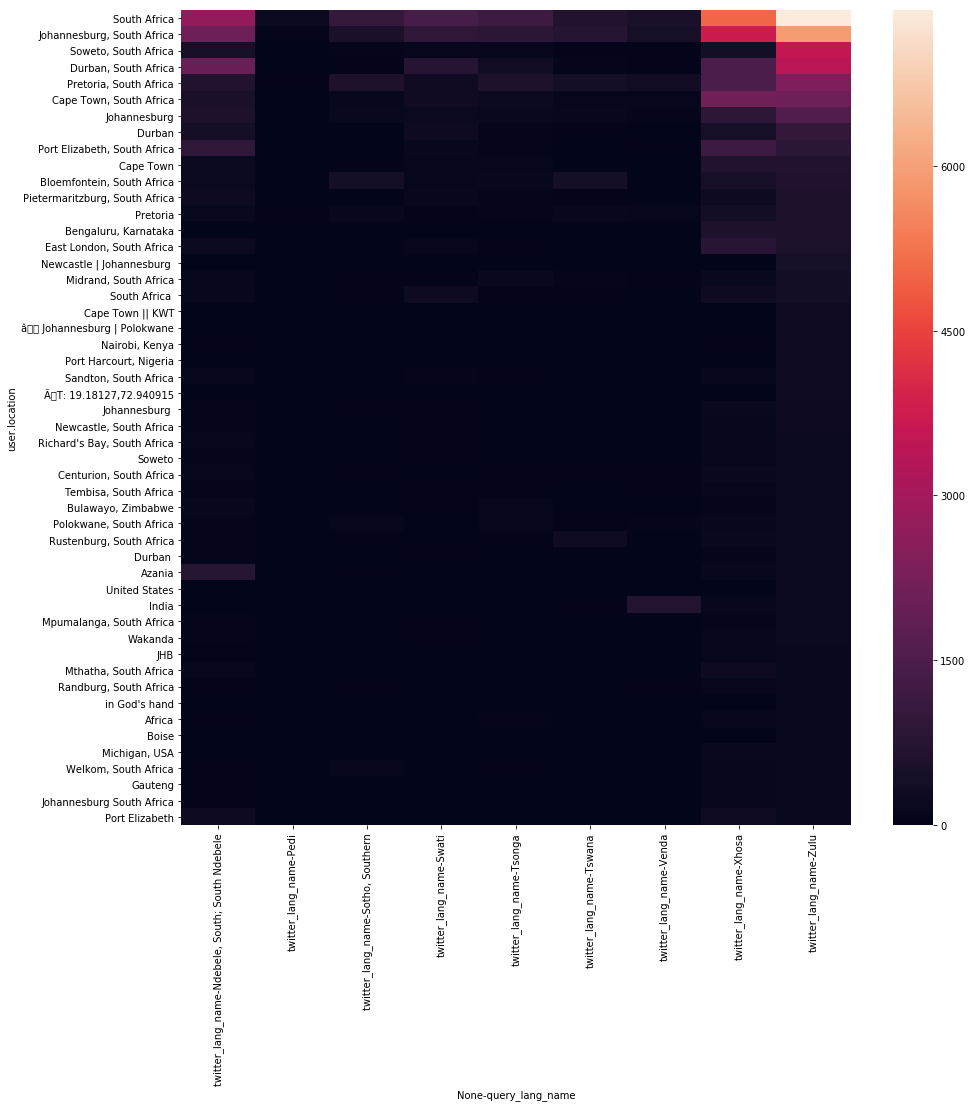

In [59]:
df_pivot = pd.pivot_table(tweets[['twitter_lang_name','query_lang_name','user.location']], 
               index='user.location', 
               columns='query_lang_name', 
               aggfunc='count')

idx = df_pivot[('twitter_lang_name', 'Zulu')].reset_index().sort_values(('twitter_lang_name', 'Zulu'),ascending=False).index

fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_pivot.fillna(0).iloc[idx.tolist()].iloc[0:50], ax=ax)

### Location - prediction comparison

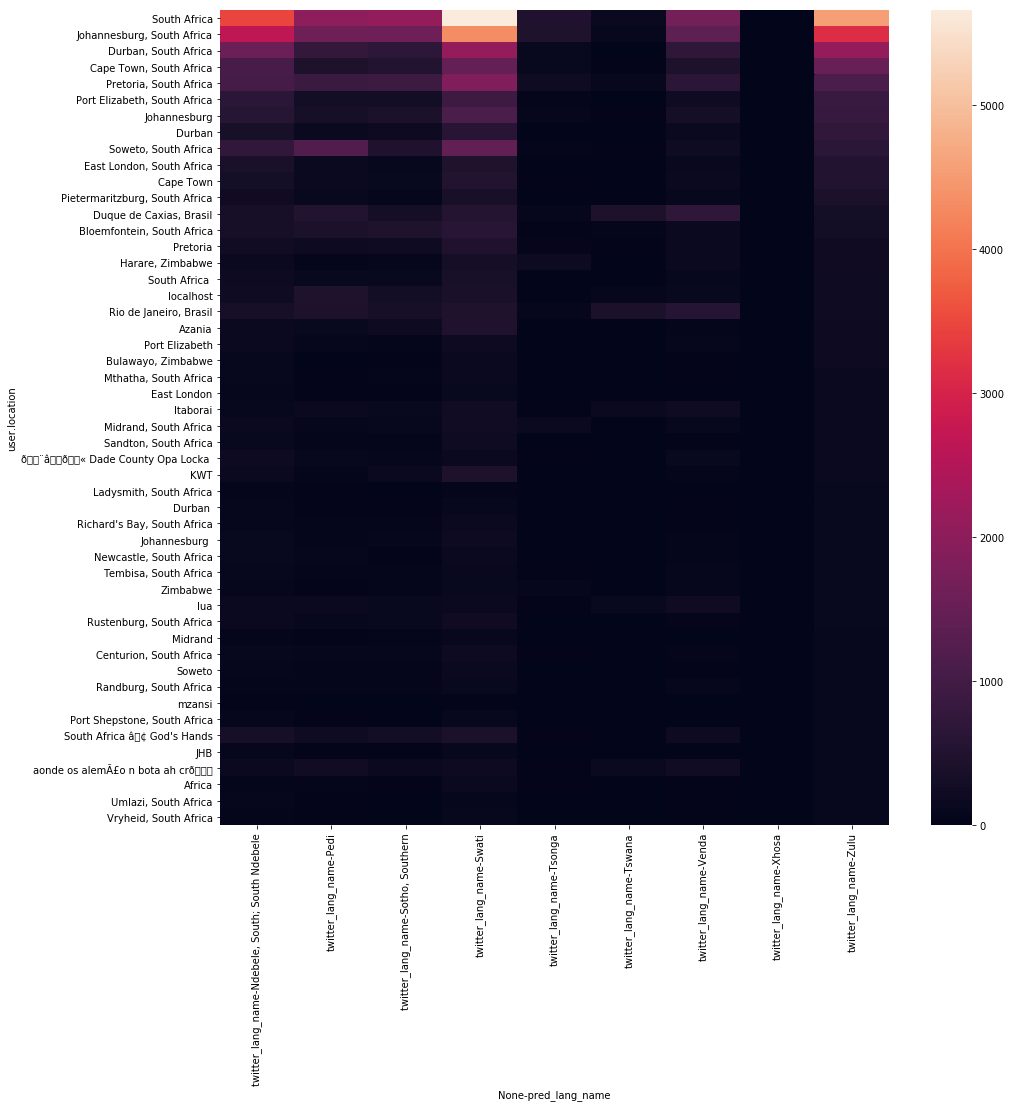

In [62]:
df_pivot = pd.pivot_table(tweets[['twitter_lang_name','pred_lang_name','user.location']], 
               index='user.location', 
               columns='pred_lang_name', 
               aggfunc='count')

idx = df_pivot[('twitter_lang_name', 'Zulu')].reset_index().sort_values(('twitter_lang_name', 'Zulu'),ascending=False).index

fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_pivot.fillna(0).iloc[idx.tolist()].iloc[0:50], ax=ax)

### Time zone - prediction comparison

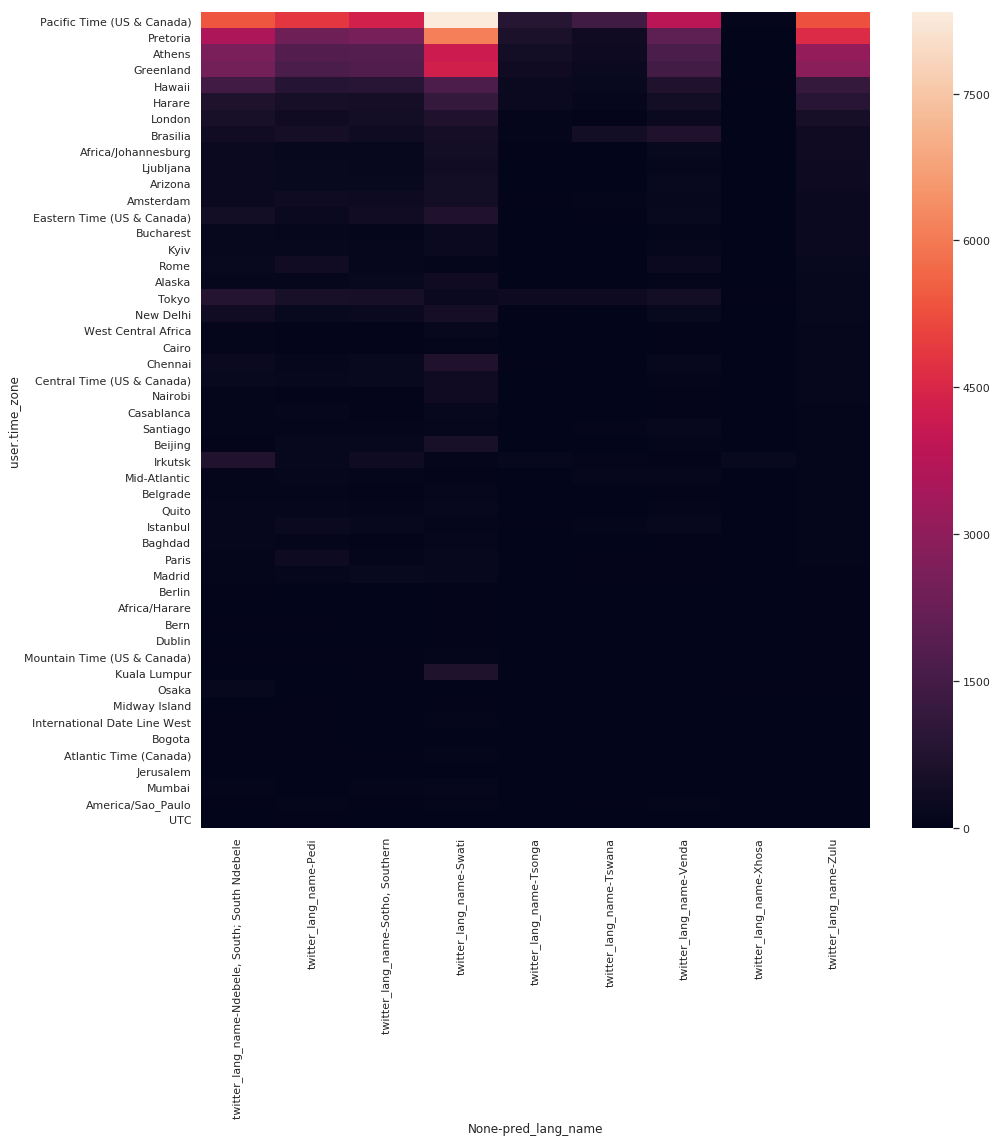

In [400]:
df_pivot = pd.pivot_table(tweets[['twitter_lang_name','pred_lang_name','user.time_zone']], 
               index='user.time_zone', 
               columns='pred_lang_name', 
               aggfunc='count')

idx = df_pivot[('twitter_lang_name', 'Zulu')].reset_index().sort_values(('twitter_lang_name', 'Zulu'),ascending=False).index

fig, ax = plt.subplots(figsize=(15, 15))

sns.heatmap(df_pivot.fillna(0).iloc[idx.tolist()].iloc[0:50], ax=ax)

```




```

# Word clouds

- [back to content](#Content)

- [Overall wordclouds](#Overall-wordclouds)
- [Query language wordclouds](#Query-language-wordclouds)
- [Predicted language wordclouds](#Predicted-language-wordclouds)

In [131]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.feature_extraction.text import CountVectorizer,  TfidfTransformer
from sklearn.pipeline import Pipeline

In [128]:
def plot_formatter(plt, figsize=tuple, title=' ', x_label=' ', y_label=' '):
    plt.figure(figsize=figsize)
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

In [129]:
def word_cloud(word_dict={}, param_dict={},  title='', x_label='', y_label='',  figsize=tuple):
    """
    A function to produce a word cloud

    Parameters
    ----------
    word_dict: dictionary
        A dictionary of words with word counts produce a word cloud

    param_dict: dictionary
        A dictionary specifying the wordcloud parameters.
        *Use help(WordCloud) to view entire docstring

        Examples:

        max_words : number (default=200)
            The maximum number of words.

        background_color : color value (default="black")
            Background color for the word cloud image.

        max_font_size : int or None (default=None)
            Maximum font size for the largest word. If None, height of the image is used.

    Returns
    -------
    out : object
        Word Cloud object producing a word cloud=

    """
    wordcloud = WordCloud(**param_dict)
    out = wordcloud.generate_from_frequencies(word_dict)
    plot_formatter(plt, figsize=figsize, title=title, x_label=x_label, y_label=y_label)
    # This is to make the displayed image appear more smoothly.
    plt.imshow(out, interpolation='bilinear')
    return out

In [174]:
text_pipeline = Pipeline([
        ('vect', CountVectorizer(stop_words='english', ngram_range=(2,2))),
        ('tfidf', TfidfTransformer())
    ])

In [175]:
pipeline_instance = text_pipeline.fit(tweets['text'])
vectors = pipeline_instance.transform(tweets['text'])

In [176]:
word_counts = vectors.sum(axis=0)

vocab = pipeline_instance.steps[0][1].get_feature_names()

word_count_df = pd.DataFrame(word_counts.T,index = vocab, columns=['counts'])

In [180]:
word_counts_top = word_count_df.sort_values('counts', ascending=False).head(100)
word_counts_top

counts
kids talented              1606.103194
talented https             1605.873716
abantwana kids             1605.806234
rt xolile_fica             1587.575466
https 5yg5mw2pbw           1584.337928
xolile_fica abantwana      1584.006061
ï¼ ï¼                      1342.545759
hamba kahle                1124.572219
ngoku https                1113.935233
kahle kahle                 904.144484
ªã ªã                       852.450297
masikhulen ngoku            848.373998
madoda ayixoki              848.373998
lendoda masikhulen          848.373998
ayixoki lendoda             848.373998
bhuda_t1 madoda             848.015787
https 83unc8ppxi            847.814866
rt bhuda_t1                 847.621652
kanti https                 793.139680
south africa                755.770382
kakhulu https               682.886179
imali https                 615.293156
à¹ à¹                       572.716576
ayat question               535.250000
names used                  535.250000
typicalmsian names          535.250000
ah chonâ                    535.250000
especially bina             535.250000
ali ahmad                   535.250000
malay ali                   535.250000
...                                ...
ukuthi uthembeni            374.705861
fearless wondered           374.705861
afraid fabricated           374.705861
uthembeni ended             374.705861
ended afraid                374.705861
make hâ                     374.521664
thandiswamazwai winnie      374.301856
https tâ                    374.242624
uzalo https                 372.029196
ªà ªà                       369.350610
best better                 367.579874
restâ isho                  367.444812
inkunzi siyabonga           367.444812
mostpopulartvsoap uzalo     367.444812
kakhulu mostpopulartvsoap   367.444812
better restâ                367.444812
isho inkunzi                367.444812
ªà ¾à                       366.415126
rt uzalo_sabc1              355.217270
uzalo_sabc1 best            353.989573
ï½ ï½                       348.645128
futhi https                 329.840584
lala ngoxolo                327.745056
funza lushaka               323.456959
lushaka bursaries           320.144107
¾à µà                       317.877048
hold money                  316.393536
bursaries aren              316.263547
nsfas funza                 316.263547
aren poor                   316.263547

[100 rows x 1 columns]

```





```
## Overall wordclouds

- [contacts](#Contacts)

- [section](#Word-clouds)

(-0.5, 399.5, 199.5, -0.5)

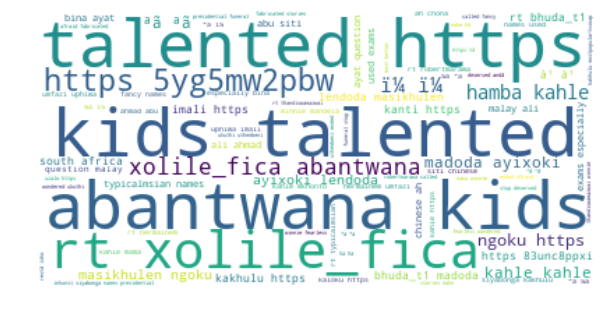

In [197]:
word_counts_top_dict = {idx:i['counts'] for idx,i in json.loads(word_counts_top.T.to_json(orient='columns')).items()}
word_cloud(word_counts_top_dict, param_dict ={'background_color': "white"}, figsize=(10,10))
plt.axis("off")

In [198]:
tweets.columns

Index(['created_at', 'id_str', 'lang', 'max_prob', 'nr', 'nso', 'our_lang',
       'pred_lang', 'pred_lang_name', 'query_lang_name',
       'quoted_status.created_at', 'quoted_status.id_str',
       'quoted_status.text', 'quoted_status.user.screen_name',
       'retweeted_status.created_at', 'retweeted_status.id_str',
       'retweeted_status.text', 'retweeted_status.user.screen_name', 'ss',
       'st', 'text', 'tn', 'ts', 'twitter_lang_name', 'user.description',
       'user.favourites_count', 'user.followers_count', 'user.friends_count',
       'user.id_str', 'user.lang', 'user.listed_count', 'user.location',
       'user.name', 'user.screen_name', 'user.statuses_count',
       'user.time_zone', 'user.utc_offset', 've', 'xh', 'zu', 'date',
       'date_m'],
      dtype='object')

In [200]:
def prepare_word_cloud(text, pipeline_instance, vocab):

    vectors = pipeline_instance.transform(text)

    word_counts = vectors.sum(axis=0)

    word_count_df = pd.DataFrame(word_counts.T,index = vocab, columns=['counts'])

    word_counts_top = word_count_df.sort_values('counts', ascending=False).head(100)

    word_counts_top_json = word_counts_top.T.to_json(orient='columns')

    word_counts_top_dict = {idx:i['counts'] for idx,i in json.loads(word_counts_top_json).items()}
    
    return word_counts_top_dict

```





```

## Query language wordclouds

- [content](#Content)

- [section](#Word-clouds)

This is convincingly Zulu

(-0.5, 399.5, 199.5, -0.5)

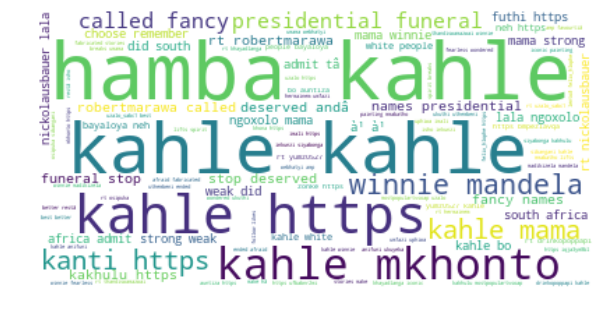

In [202]:
zulu_word_cloud = prepare_word_cloud(tweets['text'].loc[tweets['our_lang'] == 'zu'], pipeline_instance, vocab)
word_cloud(zulu_word_cloud, param_dict = {'background_color': "white"}, figsize=(10,10))
plt.axis("off")

This seems promising but still pulls out some odd characters

(-0.5, 399.5, 199.5, -0.5)

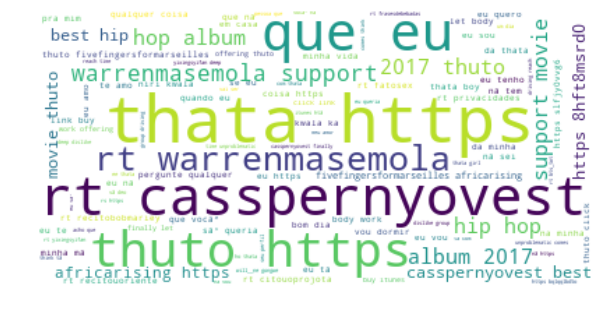

In [205]:
tswana_word_cloud = prepare_word_cloud(tweets['text'].loc[tweets['our_lang'] == 'tn'], pipeline_instance, vocab)
word_cloud(tswana_word_cloud, param_dict ={'background_color': "white"}, figsize=(10,10))
plt.axis("off")

This is not pulling out much Venda

(-0.5, 399.5, 199.5, -0.5)

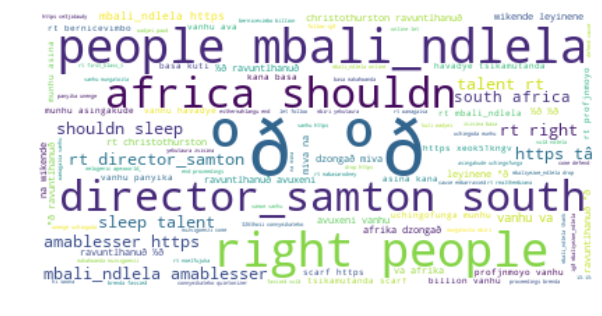

In [206]:
tsonga_word_cloud = prepare_word_cloud(tweets['text'].loc[tweets['our_lang'] == 'ts'], pipeline_instance, vocab)
word_cloud(tsonga_word_cloud, param_dict ={'background_color': "white"}, figsize=(10,10))
plt.axis("off")

This seems a little messy

(-0.5, 399.5, 199.5, -0.5)

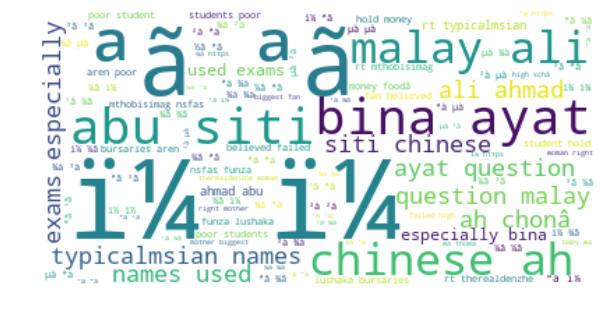

In [207]:
venda_word_cloud = prepare_word_cloud(tweets['text'].loc[tweets['our_lang'] == 've'], pipeline_instance, vocab)
word_cloud(venda_word_cloud, param_dict ={'background_color': "white"}, figsize=(10,10))
plt.axis("off")

```





```

## Predicted language wordclouds

- [contacts](#Contacts)

- [section](#Word-clouds)

This seems like a failure mode. Mostly german seems to come up. This might be the result of `tf-idf`. 

(-0.5, 399.5, 199.5, -0.5)

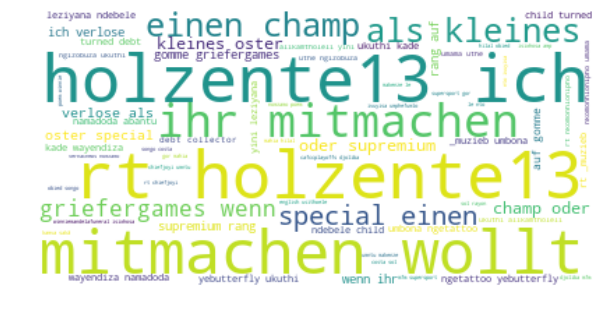

In [229]:
zu = tweets.loc[tweets['pred_lang'] == 'zu'].sort_values('max_prob', ascending=False)[['text',
                                                                                       'lang',
                                                                                  'max_prob']].iloc[0:1000]




zulu_pred_word_cloud = prepare_word_cloud(zu['text'], pipeline_instance, vocab)
word_cloud(zulu_pred_word_cloud, param_dict ={'background_color': "white"}, figsize=(10,10))
plt.axis("off")



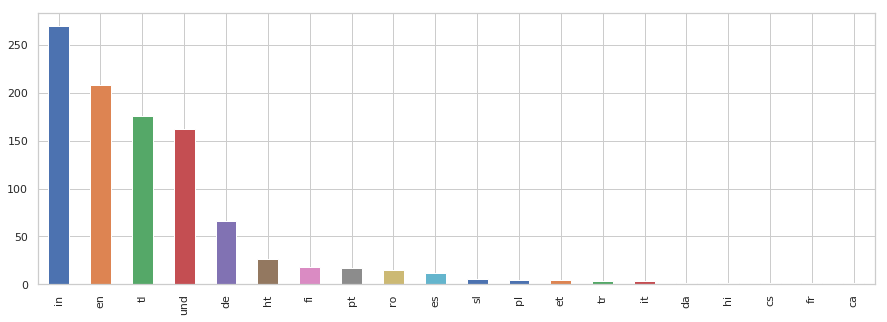

In [242]:
zu['lang'].value_counts().plot.bar(figsize=(15,5))

(-0.5, 399.5, 199.5, -0.5)

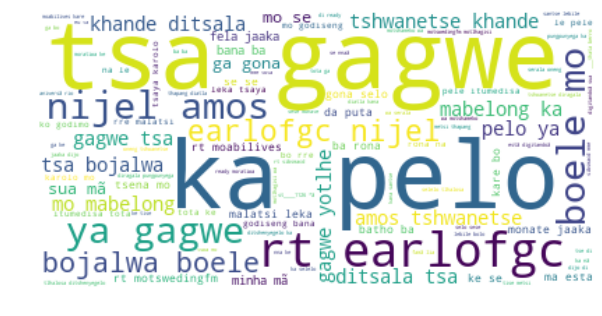

In [235]:
tn = tweets.loc[tweets['pred_lang'] == 'tn'].sort_values('max_prob', ascending=False)[['text',
                                                                                       'lang',
                                                                                  'max_prob']].iloc[0:1000]



tswana_pred_word_cloud = prepare_word_cloud(tn['text'], pipeline_instance, vocab)
word_cloud(tswana_pred_word_cloud, param_dict ={'background_color': "white"}, figsize=(10,10))
plt.axis("off")

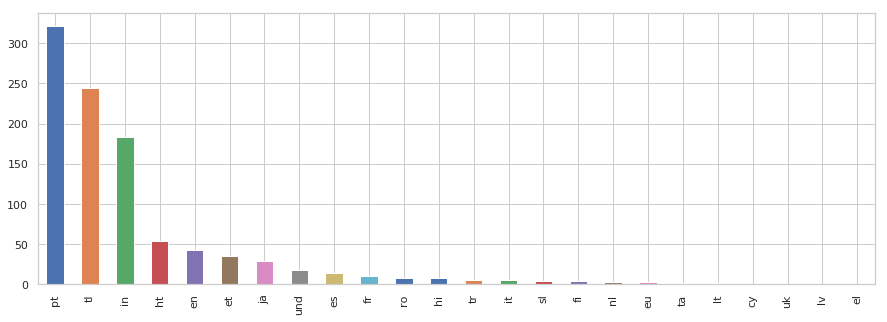

In [243]:
tn['lang'].value_counts().plot.bar(figsize=(15,5))

(-0.5, 399.5, 199.5, -0.5)

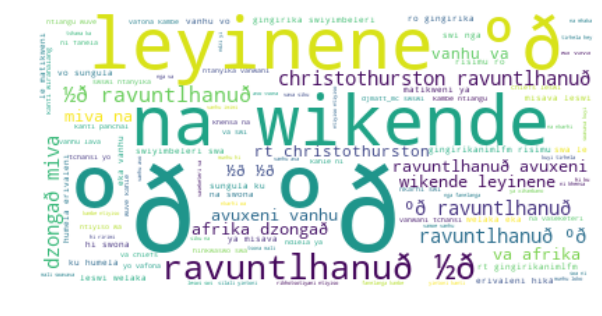

In [237]:
ts = tweets.loc[tweets['pred_lang'] == 'ts'].sort_values('max_prob', ascending=False)[['text',
                                                                                       'lang',
                                                                                  'max_prob']].iloc[0:1000]


tsonga_pred_word_cloud = prepare_word_cloud(ts['text'], pipeline_instance, vocab)
word_cloud(tsonga_pred_word_cloud, param_dict ={'background_color': "white"}, figsize=(10,10))
plt.axis("off")

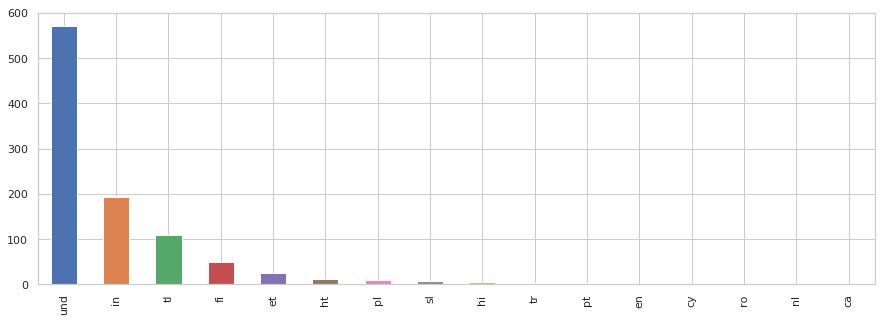

In [244]:
ts['lang'].value_counts().plot.bar(figsize=(15,5))

(-0.5, 399.5, 199.5, -0.5)

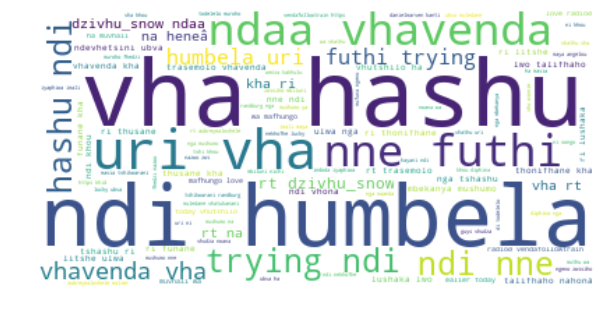

In [239]:
ve = tweets.loc[tweets['pred_lang'] == 've'].sort_values('max_prob', ascending=False)[['text',
                                                                                       'lang',
                                                                                  'max_prob']].iloc[0:1000]

venda_pred_word_cloud = prepare_word_cloud(ve['text'], pipeline_instance, vocab)
word_cloud(venda_pred_word_cloud, param_dict ={'background_color': "white"}, figsize=(10,10))
plt.axis("off")

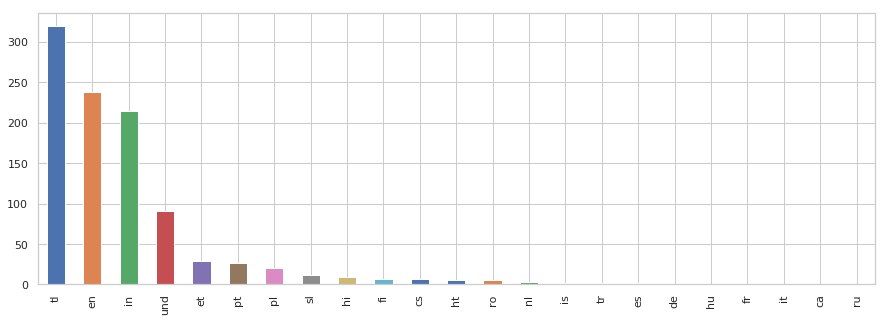

In [245]:
ve['lang'].value_counts().plot.bar(figsize=(15,5))

# Topic analysis

- [back to content](#Content)

- [topic modelling](#Topic-modelling)
- [visualisation](#Visualisation)

## Topic modelling

In [246]:
tweets.columns

Index(['created_at', 'id_str', 'lang', 'max_prob', 'nr', 'nso', 'our_lang',
       'pred_lang', 'pred_lang_name', 'query_lang_name',
       'quoted_status.created_at', 'quoted_status.id_str',
       'quoted_status.text', 'quoted_status.user.screen_name',
       'retweeted_status.created_at', 'retweeted_status.id_str',
       'retweeted_status.text', 'retweeted_status.user.screen_name', 'ss',
       'st', 'text', 'tn', 'ts', 'twitter_lang_name', 'user.description',
       'user.favourites_count', 'user.followers_count', 'user.friends_count',
       'user.id_str', 'user.lang', 'user.listed_count', 'user.location',
       'user.name', 'user.screen_name', 'user.statuses_count',
       'user.time_zone', 'user.utc_offset', 've', 'xh', 'zu', 'date',
       'date_m'],
      dtype='object')

In [248]:
tweets[['user.screen_name','retweeted_status.user.screen_name']].head(25)

user.screen_name retweeted_status.user.screen_name
0       KenethZondo                              None
1         DNEVNIKhr                             golhr
2      CrookedSwiri                              None
3      Bassy_Kojane                           czapruk
4       Thabizolo20                              None
5        juceidanas                       FicokRakije
6         RizzyRamz                     Silindokuhle_
7   Aleksan38640174                              None
8        MUSA_KHULU                        realDANITO
9         cizwe_pop                      veli_vee_rsa
10      SYAFANAZULU                              None
11     CrookedSwiri                              None
12         dlala101                              None
13   darkskin_Nandi                              None
14   DavidMashabela                          Noku0187
15            D_Lza                              None
16        phume_mad                              None
17    Qiniso_Gudazi                              None
18         punsumom                    ZimasaMatiwane
19            tilen                              None
20   londanip_ntuli                              None
21         Kuhle_xx                         localnimo
22     Kookie_Kuhle                    HolmesNicholas
23  thobela_luyanda                              None
24         PanTauuu                              None

In [251]:
tweets['user.screen_name'].value_counts().head(25)

Oliveiraa_thata    2827
life_zonke_SA      2746
mbali_ndlela       2367
Thuto_Bokisi       2073
thata_serpa        2010
BotGomme           1774
Poxx_thata         1369
mmuso_pat          1366
ryoooji_songo      1300
Khulu_Mosia        1282
Thata_silveiraa    1253
Bubu_Ndlela        1178
thoma_batospi      1140
kanti_salecha      1133
thata__gomes       1115
Sicelo_11          1110
shuma_ru           1043
tmnc_thata         1040
Thata_Santos19     1031
bakhe_buzw         1013
santooos_thata      872
SHUMA___            815
Kuhle_Mbontsi       789
malaikadiva         770
shuma_ac            742
Name: user.screen_name, dtype: int64

In [252]:
tweets['retweeted_status.user.screen_name'].value_counts().head(25)

Xolile_Fica        3905
Bhuda_T1           2376
TypicalMsian       2141
thandiswamazwai    1316
robertmarawa       1209
BABESWODUMO        1193
Uzalo_SABC1        1174
MelGawozi_SA       1140
Mthobisimag        1140
HermaineM          1058
Director_Samton     988
NickolausBauer      951
mihlalii_n          930
Zoweethabooty       919
CAGchurchzu         891
VVVinayakOnline     883
AdvBarryRoux        860
JullieOriginals     805
PokeNtwasa          769
yumz0527            764
MozzeyFlaco         746
NdiswaPearly        713
CassperNyovest      712
Pearl_Swandhle      703
Okay_Wasabi         686
Name: retweeted_status.user.screen_name, dtype: int64

In [253]:
import networkx as nx

In [278]:
tweets[['user.screen_name','retweeted_status.user.screen_name']].head(10).fillna("")

user.screen_name retweeted_status.user.screen_name
0      KenethZondo                                  
1        DNEVNIKhr                             golhr
2     CrookedSwiri                                  
3     Bassy_Kojane                           czapruk
4      Thabizolo20                                  
5       juceidanas                       FicokRakije
6        RizzyRamz                     Silindokuhle_
7  Aleksan38640174                                  
8       MUSA_KHULU                        realDANITO
9        cizwe_pop                      veli_vee_rsa

In [279]:
edge_list = tweets[['user.screen_name','retweeted_status.user.screen_name']].fillna("").apply(lambda x: ' '.join(x.tolist()),axis=1).tolist()

In [355]:
G = nx.parse_edgelist(edge_list, nodetype = str)

In [356]:
# we can export the garph for editing in Gephi
nx.write_graphml(G, "tweet.graphml")

In [337]:
r_nodes = pd.Series({i[0]:i[1] for i in degree}).sort_values(ascending=False).index.tolist()[1000::]

for i in r_nodes:
    G.remove_node(i)

layout=nx.spring_layout(G)

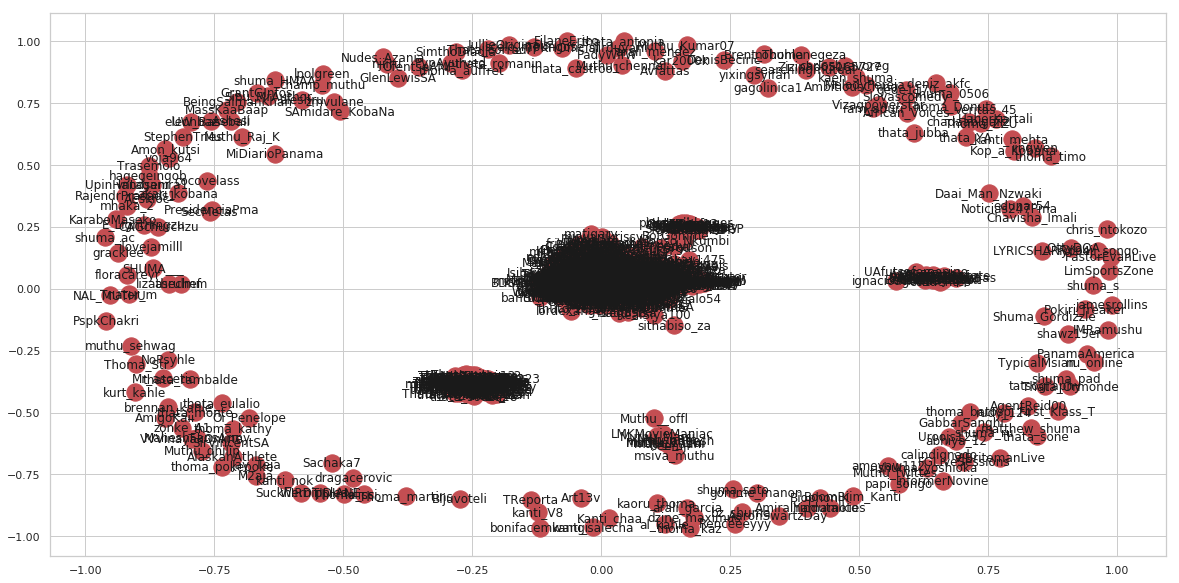

In [354]:
# plt.subplot(figsize=(10,10))
fig, ax = plt.subplots(figsize=(20, 10))
nx.draw_networkx(G,layout)
# nx.draw_networkx_edges(G,layout,width=1.0,alpha=0.5)
# nx.draw_networkx_labels(G,layout,G.nodes(),font_size=16)

In [359]:
import matplotlib.image as mpimg

Graph clustering with Gephi shows two large communities surrounded by smaller peripheral communities. The first on the left in blue seems like a Brazilian community. The reason it arises in our analysis is because of the term `thata` which seems likea Brazilian name.

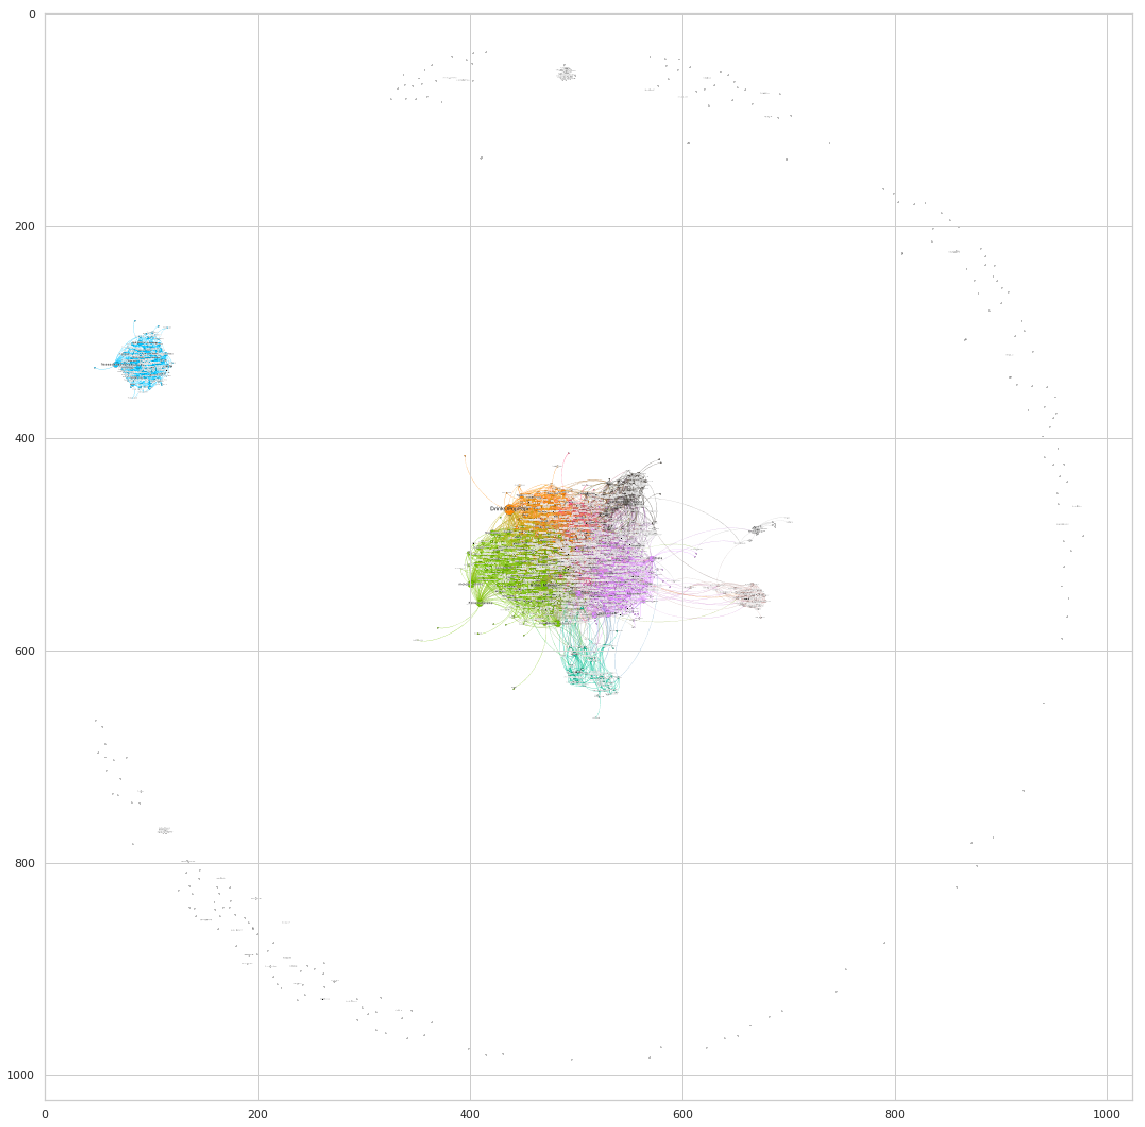

In [363]:
plt.figure(figsize=(20,20))
img=mpimg.imread('retweet_graph.png')
imgplot = plt.imshow(img)
plt.show()

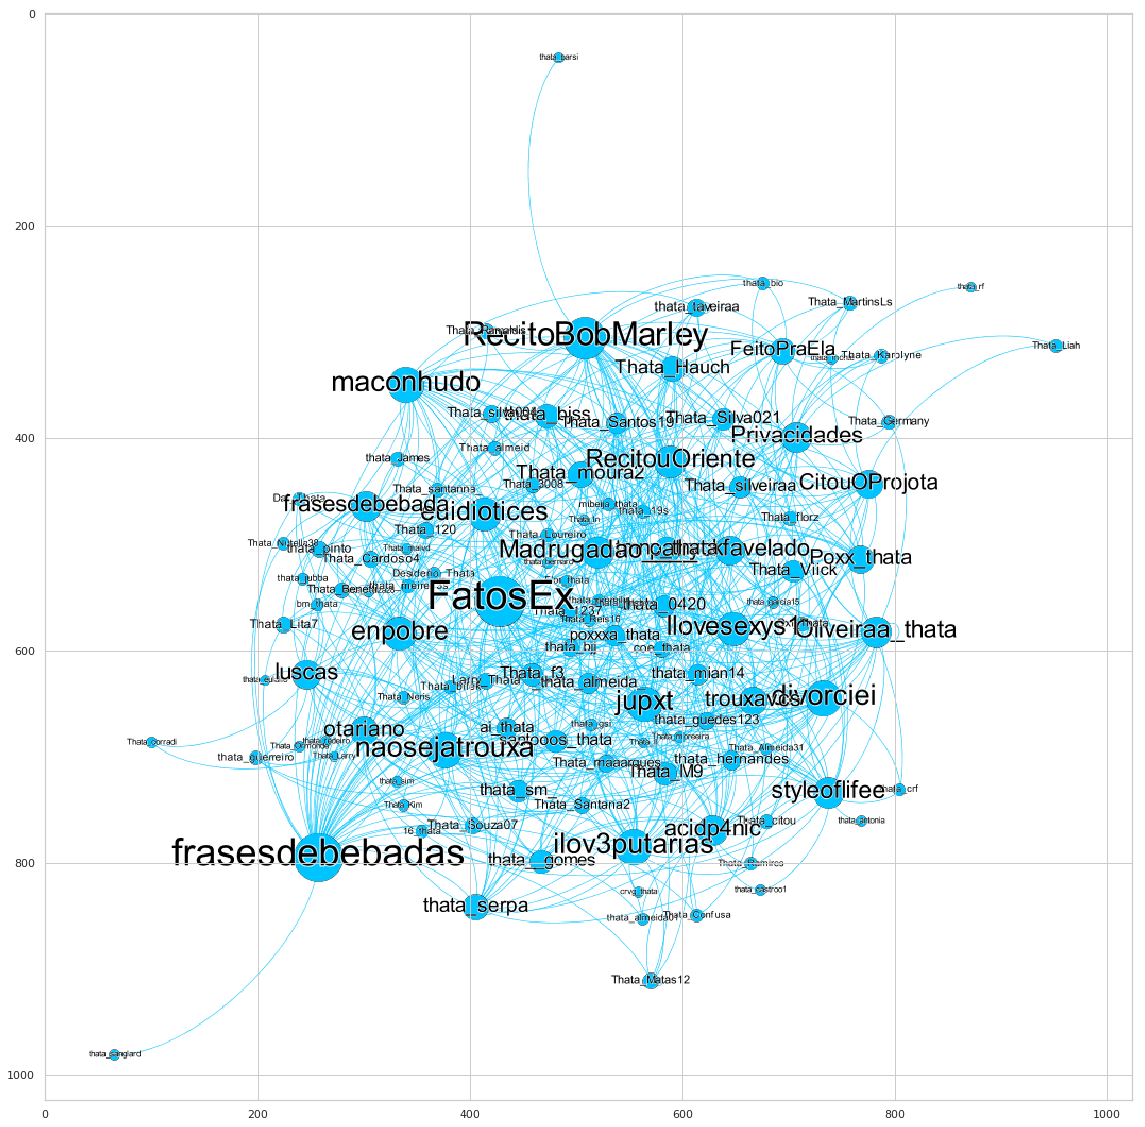

In [362]:
plt.figure(figsize=(20,20))
img=mpimg.imread('thata_class.png')
imgplot = plt.imshow(img)
plt.show()

In [364]:
tweet_mod = pd.read_csv(os.path.join(DATA_PATH,'tweet_modularity.csv'))

In [383]:
tweet_mod.shape

(112141, 5)

In [386]:
idx_label = tweets['user.screen_name'].isin(tweet_mod['Label'])
idx_retweet = tweets['retweeted_status.user.screen_name'].isin(tweet_mod['Label'])

In [390]:
idx_graph = idx_label+0+idx_retweet > 0

In [391]:
idx_graph.sum()

460018

In [402]:
# , left_on='user.screen_name', right_on='Label'

tweets_comm = tweets.merge(tweet_mod[['Label','modularity_class']], 
             how='left', 
             left_on='user.screen_name', 
             right_on='Label')

In [404]:
tweets_comm['modularity_class'].value_counts().sum()

460018

In [365]:
# 1425
# 4416
# 264 | brazilian
# 629
# 4199
# 4188
# 3672
# 2119

tweet_mod.head()

Id          Label  timeset  modularity_class  Degree
0         _Kxymo         _Kxymo      NaN              3774       1
1     kuhle_tofo     kuhle_tofo      NaN              4176       3
2  sinanalbayrak  sinanalbayrak      NaN              2523       1
3    Mazak_Japan    Mazak_Japan      NaN              4336       1
4   BashurshLife   BashurshLife      NaN              4416       2

In [381]:
(tweet_mod['modularity_class'].value_counts()/tweet_mod['modularity_class'].count())[0:10].sum()

0.5287539793652634

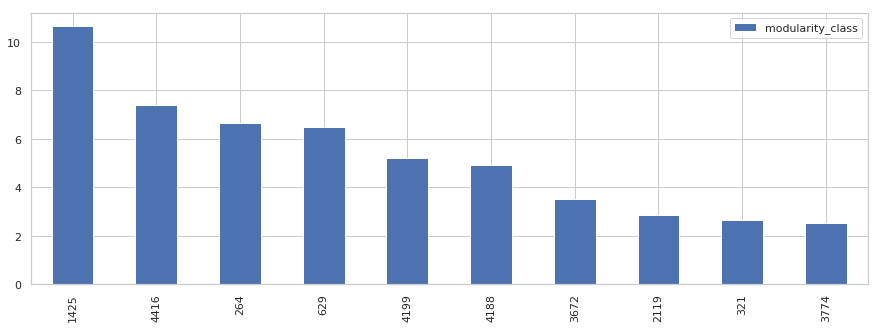

In [377]:
pd.DataFrame(100*(tweet_mod['modularity_class'].value_counts()
                  /tweet_mod['modularity_class'].count())[0:10]).plot.bar(figsize=(15,5))

In [424]:
[i for i in top_comm if i!= 264]

[1425, 4416, 629, 4199, 4188, 3672, 2119]

In [442]:
top_comm = tweet_mod['modularity_class'].value_counts().nlargest(10).index.tolist()

idx_top_mod = tweets_comm['modularity_class'].isin([i for i in top_comm if i!= 264])

In [443]:
tweets_in_comm = tweets_comm.loc[idx_top_mod]
tweets_in_comm.shape

(260759, 44)

In [445]:
zu['lang'].value_counts()

in     320
tl     219
en     202
und     87
de      70
ht      33
fi      20
ro      15
sl       9
pl       6
it       5
hi       3
tr       2
et       2
da       2
cy       2
cs       1
fr       1
ca       1
Name: lang, dtype: int64

In [447]:
zu.loc[zu['lang']!='de'].shape

(930, 3)

(-0.5, 399.5, 199.5, -0.5)

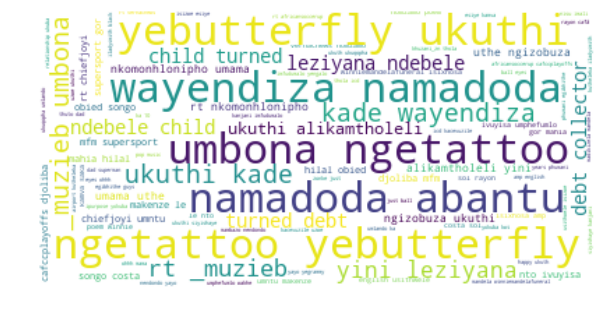

In [449]:
zu = tweets.loc[tweets['pred_lang'] == 'zu'].sort_values('max_prob', ascending=False)[['text',
                                                                                       'lang',
                                                                                  'max_prob']].iloc[0:1000]



zu = zu.loc[zu['lang']!='de']
zulu_pred_word_cloud = prepare_word_cloud(zu['text'], pipeline_instance, vocab)
word_cloud(zulu_pred_word_cloud, param_dict ={'background_color': "white"}, figsize=(10,10))
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

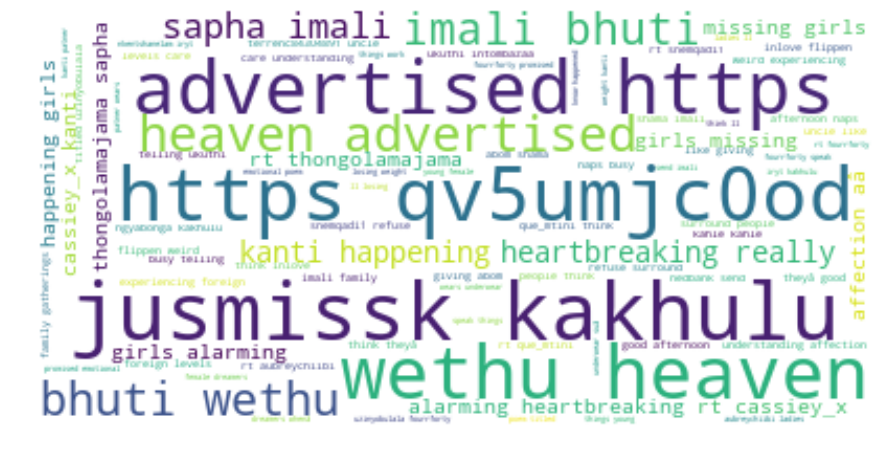

In [453]:
ss = tweets_in_comm.loc[tweets_in_comm['pred_lang'] == 'ss'].sort_values('max_prob', ascending=False)[['text',
                                                                                       'lang',
                                                                                  'max_prob']].iloc[0:1000]



# zu = zu.loc[zu['lang']!='de']
swati_pred_word_cloud = prepare_word_cloud(ss['text'], pipeline_instance, vocab)
word_cloud(swati_pred_word_cloud, param_dict ={'background_color': "white"}, figsize=(15,10))
plt.axis("off")

In [460]:
ss.sort_values(by='max_prob',ascending=False).head(25).drop_duplicates().to_csv('SiSwati_tweets.csv')

## Visualisation

In [ ]:
pd.pivot_table(ts_tweets[['our_lang','pred','user.location']].loc[tweets['pred'] == tweets['our_lang']], 
               index='our_lang', 
               columns='pred', 
               aggfunc='count')



# Final notes

- [back to content](#Content)